In [1]:
from dataset import banglachar
from models import cnntransfomer
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

In [2]:
import metadata.char as metadata
m = metadata.MAPPING
def show_label(t):
    label_length = len(t)
    label = []
    for i in range(label_length):
        idx = t[i].item()
        label.append(m[idx])    
    label = ''.join(char for char in label if char != '<P>')
    print(label) 

In [3]:
train_loader,test_loader,val_loader = banglachar.dividing_datasets()

জ্জু


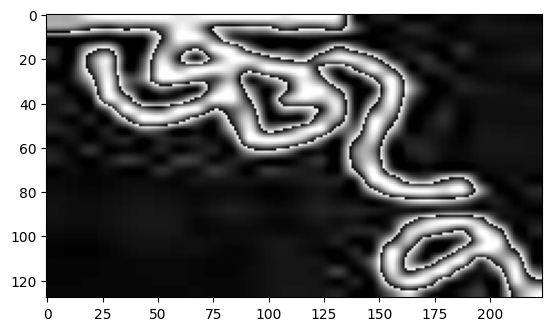

In [4]:
idx = 30032

img = train_loader.dataset[idx]['images']
target = train_loader.dataset[idx]['targets']
show_label(target)
tensor_to_pil = transforms.ToPILImage()
pil_image = tensor_to_pil(img)
plt.imshow(pil_image)
plt.show()

In [5]:
inverse_mapping = {val: ind for ind, val in enumerate(m)}
start_index = inverse_mapping["<S>"]
end_index = inverse_mapping["<E>"]
padding_index = inverse_mapping["<P>"]

ignore_tokens = [start_index, end_index, padding_index]

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=padding_index)

In [6]:
def teacher_forward(model, x, y):
    """Uses provided sequence y as guide for non-autoregressive encoding-decoding of x.

    Parameters
    ----------
    x
        Batch of images to be encoded. See self.model.encode for shape information.
    y
        Batch of ground truth output sequences.

    Returns
    -------
    torch.Tensor
        (B, C, Sy) logits
    """
    x = model.encode(x)
    output = model.decode(x, y)  # (Sy, B, C)
    return output.permute(1, 2, 0)  # (B, C, Sy)


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
 
def train_fn(model, data_loader, optimiser):
    model.train()
    fin_loss = 0
    for _, data in enumerate(data_loader):
        images, targets = data['images'], data['targets']
        x = images.to(device)
        y = targets.to(device)
        optimiser.zero_grad()
        logits = teacher_forward(model,x, y[:, :-1])
        loss = loss_fn(logits, y[:, 1:])
        loss.backward()
        optimiser.step()
        fin_loss += loss.item()
    return fin_loss/len(data_loader)     
   
def eval_fn(model, data_loader):
    model.eval()
    fin_loss = 0
    with torch.no_grad():
        
        for _, data in enumerate(data_loader):
            images, targets = data['images'], data['targets']
            x = images.to(device)
            y = targets.to(device)
            logits = teacher_forward(model,x, y[:, :-1])
            loss = loss_fn(logits, y[:, 1:])
            fin_loss += loss.item()
        return fin_loss/len(data_loader)       

In [8]:
model = cnntransfomer.CNNTransformer().to(device)

optimiser = torch.optim.Adam(model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, factor=0.8, patience=5 ,verbose=True
)

train_losses = []
valid_losses = []
for epoch in range(100):
    train_loss = train_fn(model,train_loader,optimiser)
    valid_loss = eval_fn(model,val_loader)
    print(f"Epoch {epoch}:\nTrain loss: {train_loss}, val loss: {valid_loss}")
    
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    scheduler.step(valid_loss)

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 0:
Train loss: nan, val loss: 3.2904220949305167
Epoch 1:
Train loss: nan, val loss: 3.2131306599019442
Epoch 2:
Train loss: nan, val loss: 3.3530293573247323
Epoch 3:
Train loss: nan, val loss: 3.2756197068107853
Epoch 4:
Train loss: nan, val loss: 3.473397069806931
Epoch 5:
Train loss: nan, val loss: 3.4995072626494284
Epoch 6:
Train loss: nan, val loss: 3.927838606746733
Epoch 7:
Train loss: nan, val loss: 3.193998110513539
Epoch 8:
Train loss: nan, val loss: 3.1854884091664575
Epoch 9:
Train loss: nan, val loss: 3.2791239975871256
Epoch 10:
Train loss: nan, val loss: 3.213504778782414
Epoch 11:
Train loss: nan, val loss: 3.1728779230967605
Epoch 12:
Train loss: nan, val loss: 3.1833639411305774
Epoch 13:
Train loss: nan, val loss: 3.251875713151449
Epoch 14:
Train loss: nan, val loss: 3.1729070873880993
Epoch 15:
Train loss: nan, val loss: 3.120164665845361
Epoch 16:
Train loss: nan, val loss: 3.1087453183224043
Epoch 17:
Train loss: nan, val loss: 3.034135156170145
Epoch 18:

KeyboardInterrupt: 

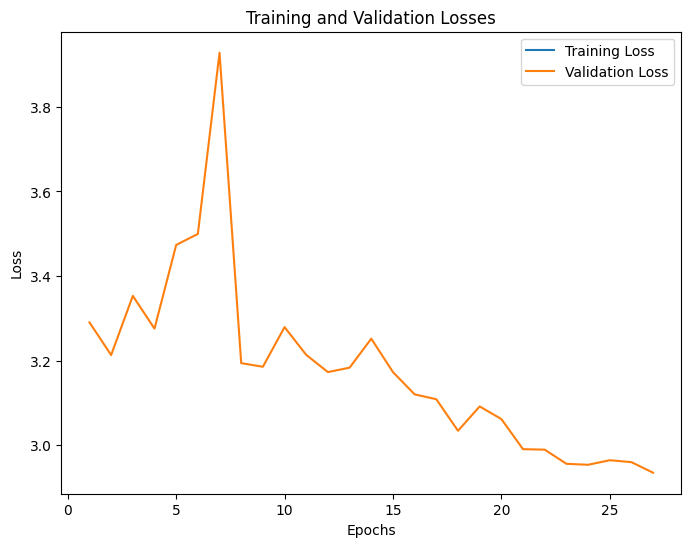

In [12]:
epochs = range(1, 27 + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()    